#Project Diary
This document act as a project diary for **Happy Tweeting**



###Citation Information
@InProceedings{paws2019naacl,<br>
title = {{TSATC: Twitter Sentiment Analysis Training Corpus}},<br>
author = {Ibrahim Naji},<br>
booktitle = {thinknook},<br>
year = {2012}<br>
}

1 stands for positive,<br>
0 for negative

Dataset retrieved from:<br>
https://huggingface.co/datasets/carblacac/twitter-sentiment-analysis/tree/main

In [1]:
_URL = "https://raw.githubusercontent.com/cblancac/SentimentAnalysisBert/main/data/"
_URLS = {
    "train": _URL + "train_150k.txt",
    "test": _URL + "test_62k.txt",
}


In [2]:
!wget https://raw.githubusercontent.com/cblancac/SentimentAnalysisBert/main/data/train_150k.txt
!wget https://raw.githubusercontent.com/cblancac/SentimentAnalysisBert/main/data/test_62k.txt

--2023-06-27 18:08:53--  https://raw.githubusercontent.com/cblancac/SentimentAnalysisBert/main/data/train_150k.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11697788 (11M) [text/plain]
Saving to: ‘train_150k.txt’

train_150k.txt      100%[===================>]  11.16M  --.-KB/s    in 0.06s   

2023-06-27 18:08:54 (194 MB/s) - ‘train_150k.txt’ saved [11697788/11697788]

--2023-06-27 18:08:54--  https://raw.githubusercontent.com/cblancac/SentimentAnalysisBert/main/data/test_62k.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
dfTrain = pd.read_csv("./train_150k.txt",names=["sentiment","tweets"], sep="\t")
dfTest = pd.read_csv("./test_62k.txt",names=["sentiment","tweets"], sep="\t")
dfTrain.head()

,sentiment,tweets
0,0,Starting back at work today Looks like it'l...
1,1,Sugar levels dropping... munchies setting in. ...
2,1,@karineb22 yeah!!! have a great summer break!
3,1,hannah montana was very good. now going to re...
4,1,"@Mayra326 aww, have fun! I just had my 3D las..."


In [ ]:
words = {}
lens = []
for row in dfTrain["tweets"]:
  for word in row.split():
    lens.append(len(row.split()))
    if word in words.keys():
      words[word] += 1
    else:
      words[word] = 1

words_sorted = dict(sorted(words.items(), key=lambda item: item[1], reverse=True))

In [ ]:
lens.sort(reverse=True)

(array([4.914000e+05, 1.012431e+06, 4.900260e+05, 6.030000e+02,
        4.600000e+01, 5.700000e+01, 0.000000e+00, 7.900000e+01,
        0.000000e+00, 1.110000e+02]),
 array([  1.,  12.,  23.,  34.,  45.,  56.,  67.,  78.,  89., 100., 111.]),
 <BarContainer object of 10 artists>)

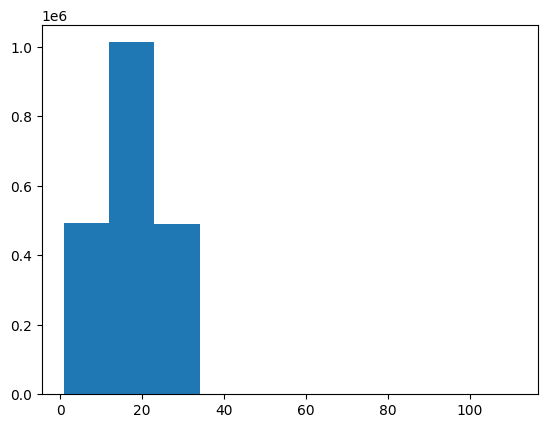

In [ ]:
plt.hist(lens)

In [ ]:
l95 = np.percentile(lens,95)

In [ ]:
len(words_sorted.keys()), sum(words_sorted.values())

(236155, 1994753)

In [ ]:
incremental = {}
current_increment = 0
increments = []
for key in words_sorted.keys():
  current_increment += words_sorted[key]
  increments.append(current_increment)
  incremental[current_increment] = key

p95 = int(sum(words_sorted.values())/100*95)
p95

1895015

In [ ]:
array = np.asarray(increments)
idx = (np.abs(array - p95)).argmin()
tokens = array[idx]

In [ ]:
incremental[tokens]

"ea'.."

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
      ("tfidf", TfidfVectorizer()),
      ("clf",MultinomialNB())
])

model_0.fit(dfTrain["tweets"],dfTrain["sentiment"])


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0_score = model_0.score(dfTest["tweets"],dfTest["sentiment"])

In [ ]:
model_0_score*100

75.93309461595535

In [ ]:
model_0_predictions = model_0.predict(dfTest["tweets"])

In [ ]:
model_0_predictions[:5]

array([1, 0, 0, 0, 0])

In [17]:
from sklearn import metrics
def evaluate_predictions(y_true,y_pred):
  output = {}
  output["accuracy"] = metrics.accuracy_score(y_true=y_true,
                                                      y_pred=y_pred)
  output["precision"] = metrics.precision_score(y_true=y_true,
                                                      y_pred=y_pred)
  output["recall"] = metrics.recall_score(y_true=y_true,
                                                      y_pred=y_pred)
  output["f1"] = metrics.f1_score(y_true=y_true, average="weighted",
                                                      y_pred=y_pred)
  return output

In [ ]:
evaluate_predictions(dfTest["sentiment"].to_numpy(),model_0_predictions)

{'accuracy': 0.7593309461595535,
 'precision': 0.8030781967336494,
 'recall': 0.6877759515292146,
 'f1': 0.7580988079001916}

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((dfTrain["tweets"],dfTrain["sentiment"])).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((dfTest["tweets"],dfTest["sentiment"])).batch(128).prefetch(tf.data.AUTOTUNE)

In [ ]:
text_vectorization = tf.keras.layers.TextVectorization(max_tokens=tokens,output_sequence_length=int(l95), pad_to_max_tokens=True)
text_vectorization.adapt(dfTrain["tweets"].to_numpy())

In [ ]:
text_vectorization(random.choice(dfTrain["tweets"].to_numpy()))

<tf.Tensor: shape=(27,), dtype=int64, numpy=
array([112256,    330,      2,     65,     41,      3,    224,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0])>

In [ ]:
vocab = text_vectorization.get_vocabulary()

In [ ]:
len(vocab)

151336

In [ ]:
input = tf.keras.Input(dtype=tf.string, shape=(1,), name="input")
x = text_vectorization(input)
x = tf.keras.layers.Embedding(input_dim=len(vocab), output_dim=128)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(input, output)

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_dataset, epochs=15, steps_per_epoch=len(train_dataset),
          validation_data=test_dataset, validation_steps = len(test_dataset))

Epoch 1/15
1172/1172 [==============================] - 49s 38ms/step - loss: 0.4896 - accuracy: 0.7619 - val_loss: 0.4467 - val_accuracy: 0.7900
Epoch 2/15
1172/1172 [==============================] - 18s 15ms/step - loss: 0.3525 - accuracy: 0.8467 - val_loss: 0.4853 - val_accuracy: 0.7783
Epoch 3/15
1172/1172 [==============================] - 17s 15ms/step - loss: 0.2371 - accuracy: 0.9036 - val_loss: 0.5453 - val_accuracy: 0.7717
Epoch 4/15
1172/1172 [==============================] - 17s 15ms/step - loss: 0.1758 - accuracy: 0.9304 - val_loss: 0.6237 - val_accuracy: 0.7628
Epoch 5/15
1172/1172 [==============================] - 17s 15ms/step - loss: 0.1391 - accuracy: 0.9453 - val_loss: 0.6810 - val_accuracy: 0.7649
Epoch 6/15
1172/1172 [==============================] - 17s 14ms/step - loss: 0.1152 - accuracy: 0.9552 - val_loss: 0.7739 - val_accuracy: 0.7615
Epoch 7/15
1172/1172 [==============================] - 17s 15ms/step - loss: 0.0988 - accuracy: 0.9612 - val_loss: 0.8054 -

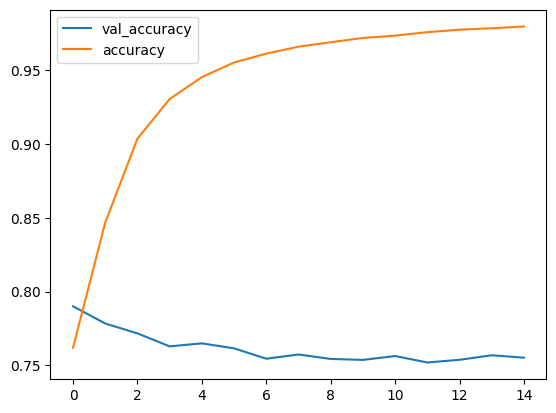

In [ ]:
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.plot(history.history["accuracy"], label="accuracy")
plt.legend()

In [ ]:
model_predictions = model.predict(test_dataset)

485/485 [==============================] - 6s 8ms/step


In [ ]:
model_y_pred = tf.math.round(tf.squeeze(model_predictions))

In [ ]:
model_y_pred[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 0., 0., 0., 0.], dtype=float32)>

In [ ]:
evaluate_predictions(dfTest["sentiment"].to_numpy(),model_y_pred)

{'accuracy': 0.7527017000548405,
 'precision': 0.7771656602041177,
 'recall': 0.7092397434657901,
 'f1': 0.7522381204144283}

In [ ]:
model_Conv = tf.keras.Sequential([
    text_vectorization,
    tf.keras.layers.Embedding(input_dim=len(vocab), output_dim=128),
    tf.keras.layers.Conv1D(128,5,padding="valid"),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Conv1D(128,5,padding="same"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

model_Conv.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
history_Conv = model_Conv.fit(train_dataset, epochs=15,
                              steps_per_epoch=len(train_dataset),
                              validation_data=test_dataset,
                              validation_steps = len(test_dataset))

Epoch 1/15
1172/1172 [==============================] - 46s 35ms/step - loss: 0.4992 - accuracy: 0.7552 - val_loss: 0.4649 - val_accuracy: 0.7841
Epoch 2/15
1172/1172 [==============================] - 15s 13ms/step - loss: 0.3277 - accuracy: 0.8587 - val_loss: 0.5422 - val_accuracy: 0.7489
Epoch 3/15
1172/1172 [==============================] - 16s 13ms/step - loss: 0.1842 - accuracy: 0.9256 - val_loss: 0.7377 - val_accuracy: 0.7392
Epoch 4/15
1172/1172 [==============================] - 14s 12ms/step - loss: 0.1210 - accuracy: 0.9529 - val_loss: 0.8583 - val_accuracy: 0.7392
Epoch 5/15
1172/1172 [==============================] - 14s 12ms/step - loss: 0.0948 - accuracy: 0.9634 - val_loss: 1.0352 - val_accuracy: 0.7127
Epoch 6/15
1172/1172 [==============================] - 15s 13ms/step - loss: 0.0818 - accuracy: 0.9686 - val_loss: 1.0433 - val_accuracy: 0.7324
Epoch 7/15
1172/1172 [==============================] - 15s 13ms/step - loss: 0.0681 - accuracy: 0.9740 - val_loss: 1.1222 -

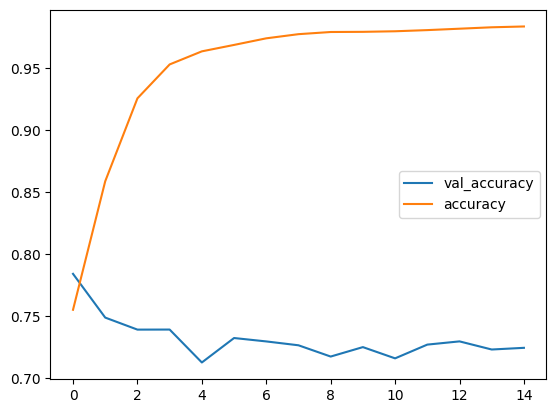

In [ ]:
plt.plot(history_Conv.history["val_accuracy"], label="val_accuracy")
plt.plot(history_Conv.history["accuracy"], label="accuracy")
plt.legend()

In [ ]:
model_Conv_predictions = model_Conv.predict(test_dataset)
model_Conv_y_pred = tf.math.round(tf.squeeze(model_Conv_predictions))
evaluate_predictions(dfTest["sentiment"], model_Conv_y_pred)

485/485 [==============================] - 1s 3ms/step


{'accuracy': 0.724491112616536,
 'precision': 0.7198197062346341,
 'recall': 0.7359889135969577,
 'f1': 0.7244532880758515}

## First Experiments
### What's been achieved so far:
* Defined a baseline model using tf-idf and naive bayes
* Preprocessing dataset in ordet to set up correctly Text Vectorization and Embeddings Layers
  * Used 95% of total words as vocabulary and 95 percentile of sequence length
* Built first model with bidirectional LSTM
  * It overfits... added "aggressive" dropout at 0.5 after each layer. Overfitting mitigated and the results are slightly better than baseline
* Built second model with Convolution 1D
  * This overfits too. Added "aggressive" dropout at 0.5 after each layere here too but not performs well...

### Next Steps to try:
* Remove special characters from input sentences
* Change vocabulary size and sequence length
* Try different kind of neural networks
* Implement some kind of tolerance:
  * for example instead of using  `tf.math.round()` and so bring to one anything above 0.5, use something to flag positive everything above 0.3



## Improve Preprocessing
The tweets were used almost as they are, now I will perform some preprocessing on the data.


In [4]:
import string
def preprocess_tweets(dataframe):
  dataframe["preprocessed_tweets"] = dataframe['tweets'].str.lower()
  for character in string.digits:
    dataframe["preprocessed_tweets"] = dataframe["preprocessed_tweets"].str.replace(character,'@')
  # removing mentions and hashtags
  dataframe['preprocessed_tweets'] = dataframe['preprocessed_tweets'].str.replace("\@[^\s]*","").str.replace('\#[^\s]*',"")
  # removing punctuation
  for character in string.punctuation:
    dataframe["preprocessed_tweets"] = dataframe["preprocessed_tweets"].str.replace(character,'')
  #dataframe['preprocessed_tweets']= dataframe['preprocessed_tweets'].str.replace('\#[^\s]*',"")

  dataframe["words"] = dataframe["preprocessed_tweets"].str.split().str.len()
  #dataframe["len"] = dataframe["preprocessed_tweets"].str.len()

preprocess_tweets(dfTrain)
preprocess_tweets(dfTest)
dfTrain.head()



<ipython-input-4-2a9c5b7040f2>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe['preprocessed_tweets'] = dataframe['preprocessed_tweets'].str.replace("\@[^\s]*","").str.replace('\#[^\s]*',"")
<ipython-input-4-2a9c5b7040f2>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dataframe["preprocessed_tweets"] = dataframe["preprocessed_tweets"].str.replace(character,'')
<ipython-input-4-2a9c5b7040f2>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe['preprocessed_tweets'] = dataframe['preprocessed_tweets'].str.replace("\@[^\s]*","").str.replace('\#[^\s]*',"")
<ipython-input-4-2a9c5b7040f2>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regu

,sentiment,tweets,preprocessed_tweets,words
0,0,Starting back at work today Looks like it'l...,starting back at work today looks like itll...,16
1,1,Sugar levels dropping... munchies setting in. ...,sugar levels dropping munchies setting in luck...,16
2,1,@karineb22 yeah!!! have a great summer break!,yeah have a great summer break,6
3,1,hannah montana was very good. now going to re...,hannah montana was very good now going to rea...,10
4,1,"@Mayra326 aww, have fun! I just had my 3D las...",aww have fun i just had my last week,9


In [ ]:
words = dfTrain["words"].to_numpy()
l95 = np.percentile(words,95)
l95

24.0

In [ ]:
words = {}
for row in dfTrain["preprocessed_tweets"]:
  for word in row.split():
    if word in words.keys():
      words[word] += 1
    else:
      words[word] = 1

words_sorted = dict(sorted(words.items(), key=lambda item: item[1], reverse=True))

In [ ]:
len(words_sorted.keys())

86969

In [ ]:
np.array(words_sorted.values())

In [ ]:
incremental = {}
current_increment = 0
increments = []
for key in words_sorted.keys():
  current_increment += words_sorted[key]
  increments.append(current_increment)
  incremental[current_increment] = key

p95 = int(sum(words_sorted.values())/100*95)
array = np.asarray(increments)
idx = (np.abs(array - p95)).argmin()
words_95 = array[idx] #there was an error before!

In [ ]:
words_95, incremental[words_95], words_sorted[incremental[words_95]], len({key:val for key, val in words_sorted.items() if val >= words_sorted[incremental[words_95]]})

(1778964, 'prego', 4, 15832)

Trying to cover the 95% of the dictionary, the model will consider also words that appears only 4 times.

In [ ]:
threshold = int(np.mean(np.array(list(words_sorted.values()))))

In [ ]:
threshold

21

In [ ]:
words_sorted_threshold = {key:val for key, val in words_sorted.items() if val >= threshold}

In [ ]:
len(words_sorted_threshold)

4827

So, with around 5000 words every word that occurs less than 21 times will be removed but in order to cover the 95% of the dictionary I need almost 16000 words.
Let's try with a middle ground: 10000 words in the dictionary

In [ ]:
tokens = 10000

In [ ]:
text_vectorization = tf.keras.layers.TextVectorization(max_tokens=tokens,output_sequence_length=int(l95), pad_to_max_tokens=True)
text_vectorization.adapt(dfTrain["tweets"].to_numpy())

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((dfTrain["preprocessed_tweets"], dfTrain["sentiment"].to_numpy())).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((dfTest["preprocessed_tweets"], dfTest["sentiment"].to_numpy())).batch(128).prefetch(tf.data.AUTOTUNE)

In [ ]:
input = tf.keras.Input(dtype=tf.string, shape=(1,), name="input")
x = text_vectorization(input)
x = tf.keras.layers.Embedding(input_dim=tokens, output_dim=128)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(input, output)

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_accuracy")

In [ ]:
history = model.fit(train_dataset, epochs=15, steps_per_epoch=len(train_dataset),
          validation_data=test_dataset, validation_steps = len(test_dataset),
                    callbacks=[early_stopping])

Epoch 1/15
1172/1172 [==============================] - 39s 30ms/step - loss: 0.5662 - accuracy: 0.7008 - val_loss: 0.4886 - val_accuracy: 0.7718
Epoch 2/15
1172/1172 [==============================] - 14s 12ms/step - loss: 0.4637 - accuracy: 0.7920 - val_loss: 0.4765 - val_accuracy: 0.7726
Epoch 3/15
1172/1172 [==============================] - 12s 10ms/step - loss: 0.4419 - accuracy: 0.8030 - val_loss: 0.4730 - val_accuracy: 0.7742
Epoch 4/15
1172/1172 [==============================] - 13s 11ms/step - loss: 0.4295 - accuracy: 0.8070 - val_loss: 0.4691 - val_accuracy: 0.7732
Epoch 5/15
1172/1172 [==============================] - 12s 11ms/step - loss: 0.4193 - accuracy: 0.8084 - val_loss: 0.4632 - val_accuracy: 0.7802
Epoch 6/15
1172/1172 [==============================] - 12s 11ms/step - loss: 0.4093 - accuracy: 0.8113 - val_loss: 0.4692 - val_accuracy: 0.7774
Epoch 7/15
1172/1172 [==============================] - 12s 11ms/step - loss: 0.3989 - accuracy: 0.8131 - val_loss: 0.4717 -

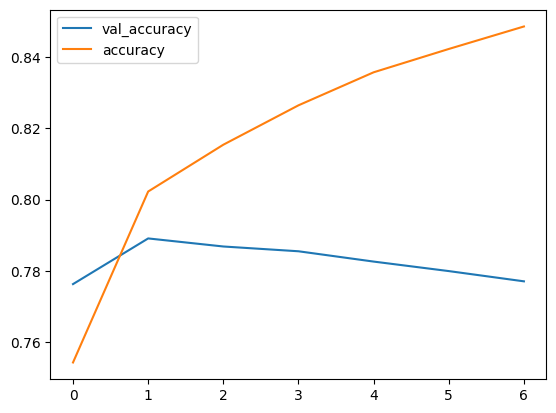

In [ ]:
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.plot(history.history["accuracy"], label="accuracy")
plt.legend()

In [ ]:
model_preds = model.predict(test_dataset)
model_y_preds = tf.math.round(tf.squeeze(model_preds))
evaluate_predictions(dfTest["sentiment"].to_numpy(),model_y_preds)

485/485 [==============================] - 2s 4ms/step


{'accuracy': 0.7763637536694732,
 'precision': 0.8187964338781575,
 'recall': 0.710367720519514,
 'f1': 0.7753916175703419}

Ok, there is a little improvement from the naive bayes, but now let's see how transfer learning performs

## Feature Extraction with Universal Sentence Extractor


In [6]:
import tensorflow_hub as hub
universal_sentence_extractor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                              input_shape=[],
                                              dtype=tf.string,
                                              trainable=False,
                                              name="USE")


In [ ]:
model_use = tf.keras.Sequential([
    universal_sentence_extractor,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")], name="model_use_fe")

In [ ]:
model_use.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
history_use = model_use.fit(train_dataset, epochs=15, steps_per_epoch=len(train_dataset),
                            validation_data=test_dataset, validation_steps=len(test_dataset),
                            callbacks=[early_stopping])

Epoch 1/15
1172/1172 [==============================] - 34s 25ms/step - loss: 0.4715 - accuracy: 0.7762 - val_loss: 0.4623 - val_accuracy: 0.7792
Epoch 2/15
1172/1172 [==============================] - 31s 26ms/step - loss: 0.4504 - accuracy: 0.7864 - val_loss: 0.4553 - val_accuracy: 0.7835
Epoch 3/15
1172/1172 [==============================] - 27s 23ms/step - loss: 0.4432 - accuracy: 0.7908 - val_loss: 0.4507 - val_accuracy: 0.7866
Epoch 4/15
1172/1172 [==============================] - 30s 26ms/step - loss: 0.4365 - accuracy: 0.7949 - val_loss: 0.4469 - val_accuracy: 0.7893
Epoch 5/15
1172/1172 [==============================] - 26s 23ms/step - loss: 0.4304 - accuracy: 0.7987 - val_loss: 0.4445 - val_accuracy: 0.7907
Epoch 6/15
1172/1172 [==============================] - 27s 23ms/step - loss: 0.4253 - accuracy: 0.8014 - val_loss: 0.4431 - val_accuracy: 0.7917
Epoch 7/15
1172/1172 [==============================] - 27s 23ms/step - loss: 0.4209 - accuracy: 0.8044 - val_loss: 0.4423 -

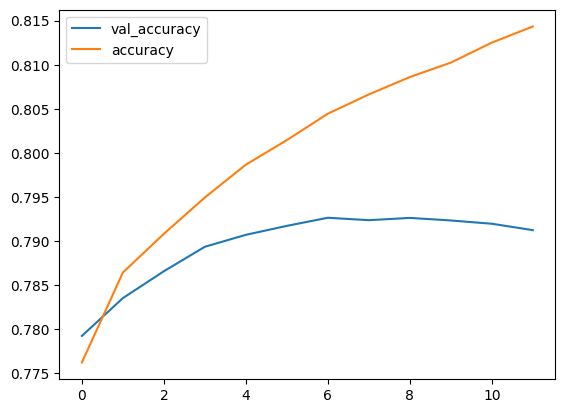

In [ ]:
plt.plot(history_use.history["val_accuracy"], label="val_accuracy")
plt.plot(history_use.history["accuracy"], label="accuracy")
plt.legend()

In [ ]:
model_use_preds = model_use.predict(test_dataset)
model_use_y_preds = tf.math.round(tf.squeeze(model_use_preds))
evaluate_predictions(dfTest["sentiment"].to_numpy(),model_use_y_preds)

485/485 [==============================] - 8s 16ms/step


{'accuracy': 0.7912352011355205,
 'precision': 0.8030292875812614,
 'recall': 0.7723097747268685,
 'f1': 0.7911625202719533}

## Train Universal Sentence Extractor on Dataset

In [10]:
universal_sentence_extractor.trainable= True;

In [19]:
model_use_tr = tf.keras.Sequential([
    universal_sentence_extractor,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation="sigmoid"),
    ], name="model_use_gru")
model_use_tr.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_use_tr.summary()

Model: "model_use_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 256,830,721
Non-trainable params: 0
_________________________________________________________________


In [20]:
history_use_tr = model_use_tr.fit(train_dataset, epochs=15, steps_per_epoch=len(train_dataset),
                            validation_data=test_dataset, validation_steps=len(test_dataset),
                            callbacks=[early_stopping])

Epoch 1/15
1172/1172 [==============================] - 378s 296ms/step - loss: 0.0210 - accuracy: 0.9944 - val_loss: 1.3769 - val_accuracy: 0.7670
Epoch 2/15
1172/1172 [==============================] - 122s 104ms/step - loss: 0.0114 - accuracy: 0.9955 - val_loss: 1.3770 - val_accuracy: 0.7669
Epoch 3/15
1172/1172 [==============================] - 120s 103ms/step - loss: 0.0082 - accuracy: 0.9964 - val_loss: 1.6663 - val_accuracy: 0.7690
Epoch 4/15
1172/1172 [==============================] - 121s 103ms/step - loss: 0.0072 - accuracy: 0.9968 - val_loss: 1.9427 - val_accuracy: 0.7678
Epoch 5/15
1172/1172 [==============================] - 121s 103ms/step - loss: 0.0066 - accuracy: 0.9969 - val_loss: 1.6537 - val_accuracy: 0.7708
Epoch 6/15
1172/1172 [==============================] - 121s 104ms/step - loss: 0.0062 - accuracy: 0.9970 - val_loss: 1.8398 - val_accuracy: 0.7696
Epoch 7/15
1172/1172 [==============================] - 122s 104ms/step - loss: 0.0063 - accuracy: 0.9970 - val_

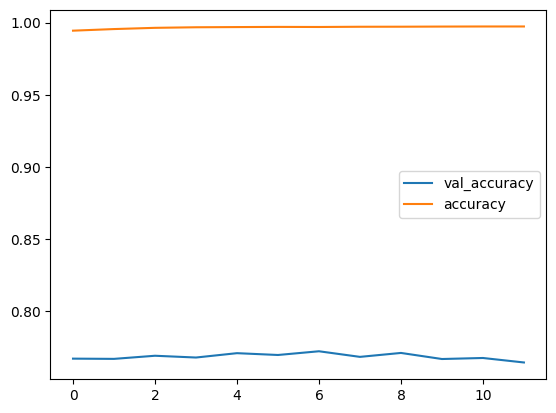

In [21]:
plt.plot(history_use_tr.history["val_accuracy"], label="val_accuracy")
plt.plot(history_use_tr.history["accuracy"], label="accuracy")
plt.legend()

In [23]:
model_use_tr_preds = model_use_tr.predict(test_dataset)
model_use_tr_y_preds = tf.math.round(tf.squeeze(model_use_tr_preds))
evaluate_predictions(dfTest["sentiment"].to_numpy(),model_use_tr_y_preds)

485/485 [==============================] - 9s 19ms/step


{'accuracy': 0.7643633665602116,
 'precision': 0.7876865933141776,
 'recall': 0.7244513197331529,
 'f1': 0.7639915622870085}